In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn import preprocessing

import pickle
import dill

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, SVGD, RBFSteinKernel, Trace_ELBO, NUTS, MCMC
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive
from pyro.nn import DenseNN

import numpy as np

import matplotlib.pyplot as plt

import os

from TurbulenceNetwork import TurbulenceNetworkBayesian
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from Model_utils import *
from Data_utils import *


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

## Bayesian Specific Utilities

In [2]:
def save_pyro_model(model, guide, path, chkpt_name="pyro"):
    torch.save({"model": model.state_dict(), "guide": guide}, os.path.join(path, chkpt_name+"_model.pt"))
    pyro.get_param_store().save(os.path.join(path, chkpt_name+"_params.pt"))

def load_pyro_model(model, path, chkpt_name="pyro"):
    saved_model_dict = torch.load(os.path.join(path, chkpt_name+"_model.pt"))
    model.load_state_dict(saved_model_dict["model"])
    guide = saved_model_dict["guide"]
    pyro.get_param_store().load(os.path.join(path, chkpt_name+"_params.pt"), device)
    pyro.module('module', model, update_module_params=True)
    pyro.module('guide', guide, update_module_params=True)
    return model, guide

## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/TurbulenceClosureDataGenerator.py:85: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)*np.sqrt(-a**3/27))


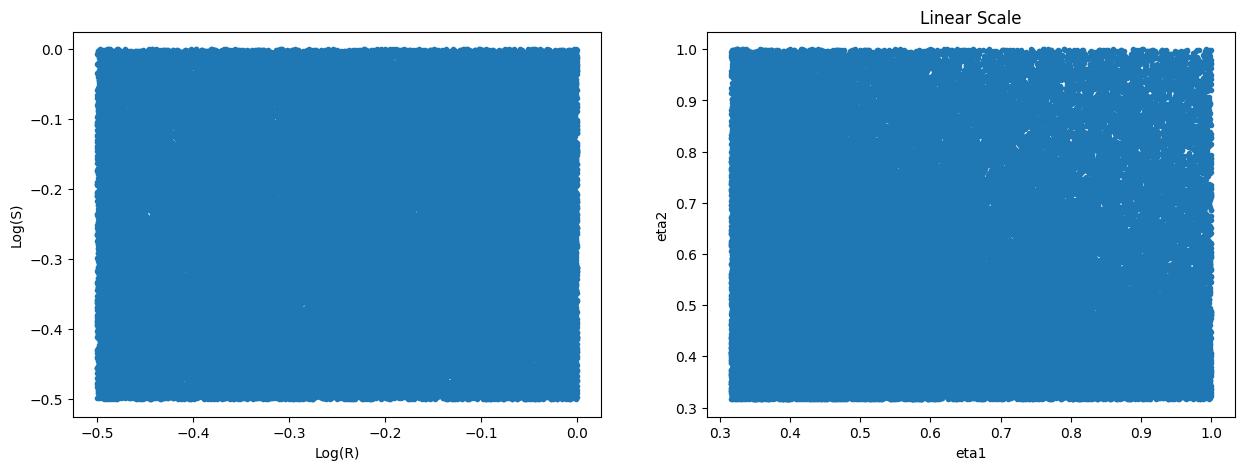

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 70_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(np.log10(np.sqrt(etas_train)))




## Training Parameters

In [4]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 50,
    "residual_blocks": 1,
    "layer_per_residual": 1,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device),
    "device": device,
    "output_prior": torch.tensor([.05], device=device)
}

In [5]:
model = TurbulenceNetworkBayesian(**model_params).to(device)

display(model)

guide = AutoDiagonalNormal(model)

adam = Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=2))

#kernel = RBFSteinKernel()
#svgd = SVGD(model, kernel=kernel, optim=adam, num_particles=50, max_plate_nesting=0)


TurbulenceNetworkBayesian(
  (stem): PyroLinear(in_features=2, out_features=50, bias=True)
  (layers): PyroModuleList(
    (0): BayesianLinearResidualBlock(
      (layers): PyroModuleList(
        (0): BayesianLinearResidual(
          (linear): PyroLinear(in_features=50, out_features=50, bias=True)
          (activation): ReLU()
        )
      )
    )
  )
  (output): PyroLinear(in_features=50, out_features=3, bias=True)
)

## Defining Datasets

In [6]:
x_scaler = preprocessing.StandardScaler().fit(etas_train)
y_scaler = preprocessing.StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=512, shuffle=True)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32).to(device)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32).to(device)

## MCMC Training

In [15]:
pyro.clear_param_store()

x_train = x_train.to(device)
y_train = y_train.to(device)

nuts_kernel = NUTS(model, max_tree_depth=1024)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=5000, num_chains=5, mp_context="spawn")

mcmc.run(x_train, y_train)
mcmc.summary()

Warmup [1]:   0%|          | 0/6000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/6000 [00:00, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/home/codygrogan/.local/lib/python3.12/site-packages/torch/__init__.py:725: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
/home/codygrogan/.local/lib/python3.12/site-pa

KeyboardInterrupt: 

In [12]:
mcmc.sampler = None
with open(r"Model_Checkpoints/mcmc_model.pkl", "wb") as output_file:
    dill.dump(mcmc, output_file)

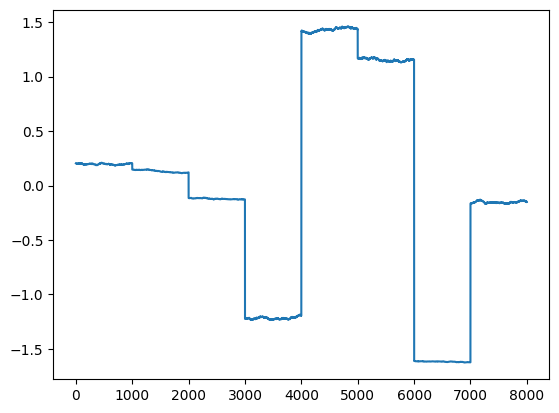

In [8]:
with open(r"Model_Checkpoints/mcmc_model.pkl", "rb") as input_file:
    mcmc_test = dill.load(input_file)

samples = mcmc_test.get_samples()

stem = samples['stem.weight']

param = stem

for i in range(1):
    plt.plot(stem[:, i, 0].cpu().numpy(), label=f"Weight {i}, {0}")


In [14]:
pyro.clear_param_store()

n_epochs = 1000

for epoch in range(n_epochs):
    loss = 0
    for bx_train, by_train in train_loader:
        bx_train = bx_train.to(device)
        by_train = by_train.to(device)
        loss += svi.step(bx_train, by_train)

    if epoch % 5 == 0:
        test_loss = svi.evaluate_loss(x_test, y_test)
        print(f"Epoch {epoch:8d} Test loss: {test_loss:20.4f}, Train loss: {loss:20.4f}")

Epoch        0 Test loss:        32460473.1698, Train loss:     36416276723.8858
Epoch        5 Test loss:        64112036.4802, Train loss:      6252589469.1393
Epoch       10 Test loss:        13806213.0488, Train loss:      3728342548.5776
Epoch       15 Test loss:        12398963.1158, Train loss:      2516823986.8622
Epoch       20 Test loss:         4344255.0314, Train loss:      1475947173.6423
Epoch       25 Test loss:         9121449.7975, Train loss:       945603857.3970
Epoch       30 Test loss:         5423591.0977, Train loss:       652358594.5366
Epoch       35 Test loss:         5886764.0408, Train loss:       536553641.1300
Epoch       40 Test loss:         4146895.2133, Train loss:       342304224.1132
Epoch       45 Test loss:         1135084.9556, Train loss:       279608143.3319
Epoch       50 Test loss:         4115571.2400, Train loss:       215951778.9337
Epoch       55 Test loss:         2147027.4221, Train loss:       176276247.0136
Epoch       60 Test loss:   

In [15]:
save_pyro_model(model, guide, "Model_Checkpoints")

## Loading Trained Model

In [16]:
model = TurbulenceNetworkBayesian(**model_params)

model, guide = load_pyro_model(model, "Model_Checkpoints")


parameters = pyro.get_param_store()
model = model.to(device)
guide = guide.to(device)

tensor(0.0109, dtype=torch.float64)


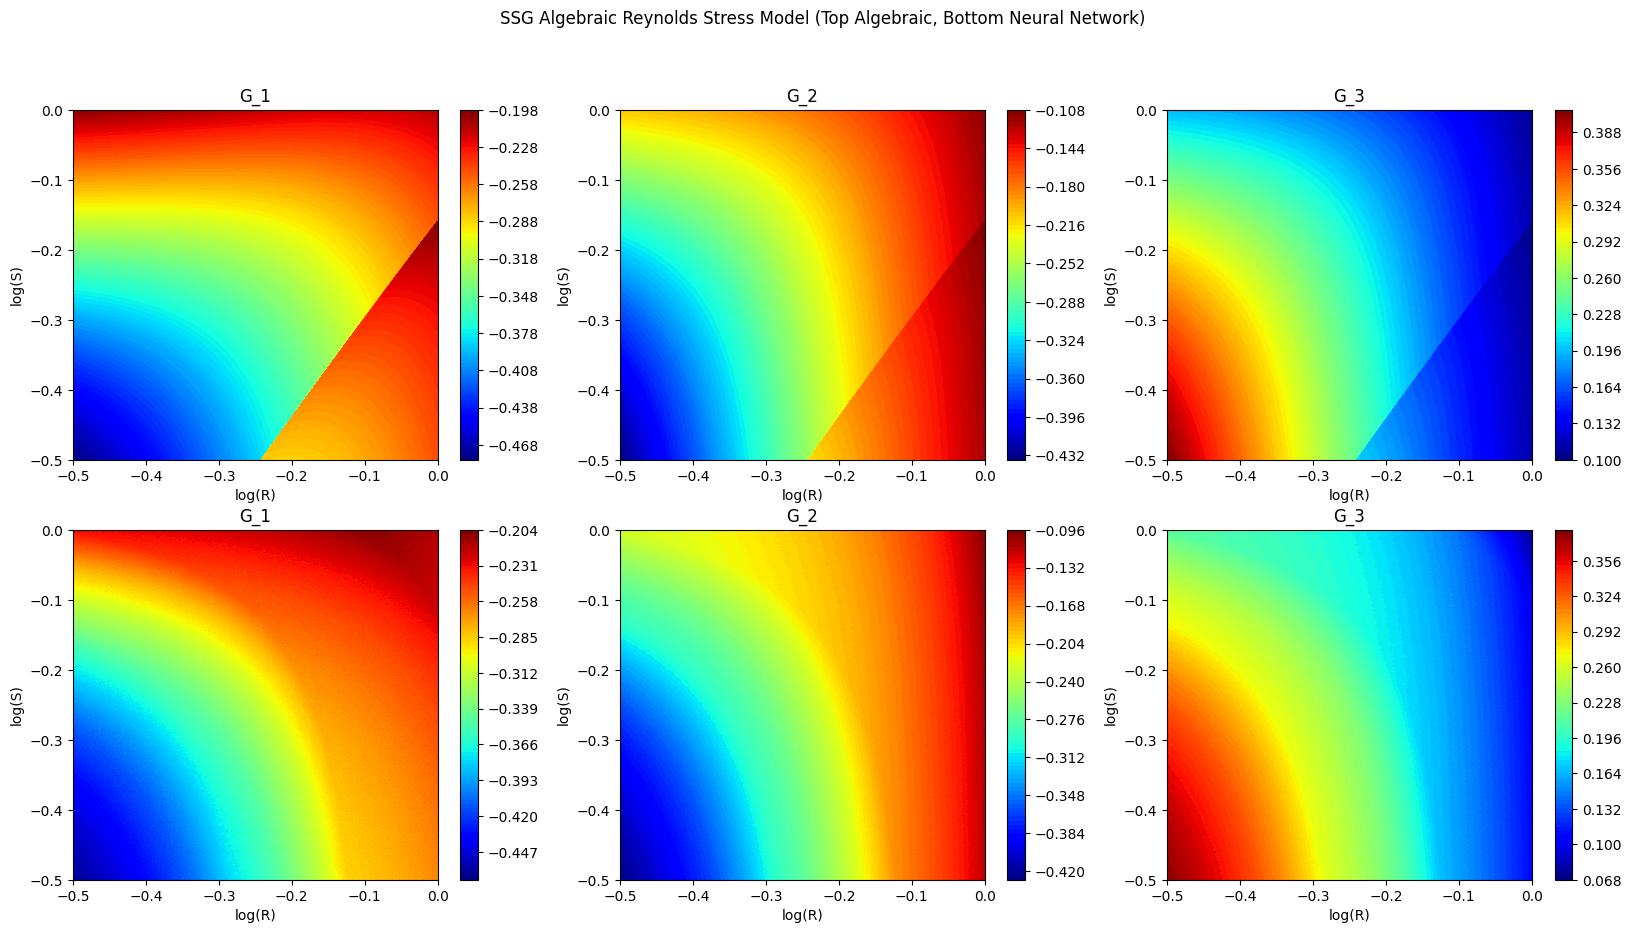

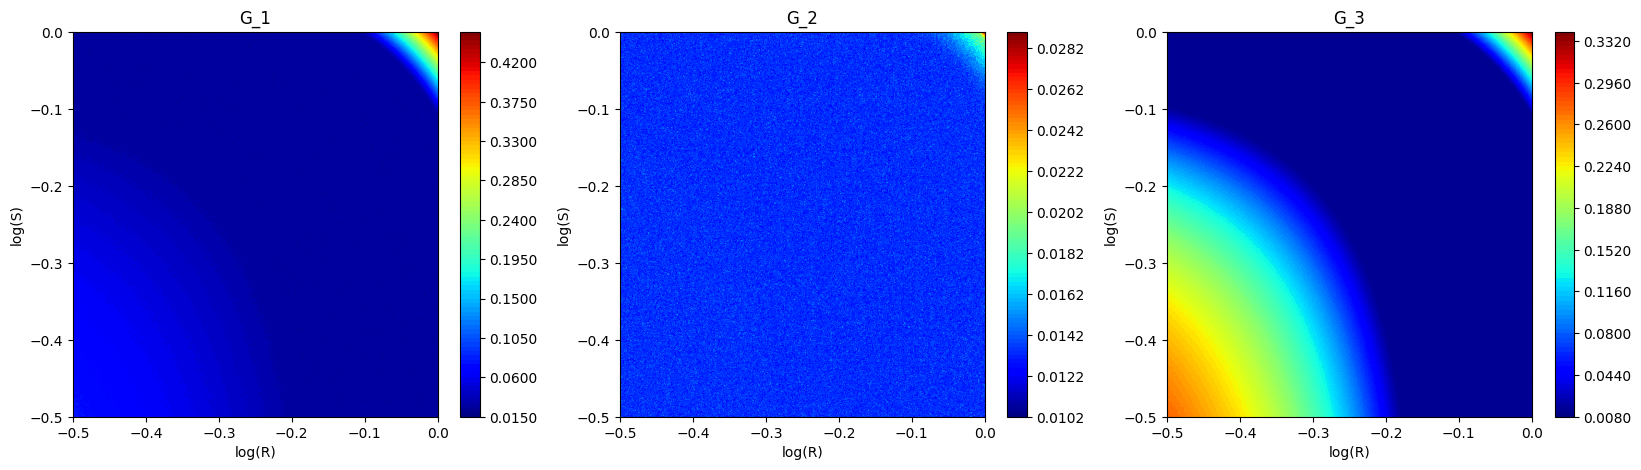

In [17]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = etas

predictive = Predictive(model, guide=guide, num_samples=250, return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))

pred_mean = torch.mean(pred["obs"], axis=0).detach().cpu()
pred_std = torch.std(pred["obs"], axis=0).detach().cpu()

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))